![Artois-Project-Logo](https://github.com/duclanruen/ArtoisProjects/blob/main/src/images/logo-banner.png?raw=true)

# Informations générales

**Département** : IUT Chimie Béthune  

**Projet** :  

*Dosage de minéraux constituants les os par spectrométrie atomique.*   

*Analyse de sensibilité des paramètres influençant les propriétés mécaniques.*  

**Etudiant** : Enzo Lopes  

**Encadrement** : Cyril Rousseau, Olivier Carpentier

# Importation des modules PIP

In [18]:
# @title
! pip install vtk pyvista panel ipywidgets trimesh

---
# Importation des modules nécessaires pour Python

In [19]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import os
import requests
import vtk
import pyvista as pv
from google.colab import output
output.enable_custom_widget_manager()
import ipywidgets as widgets
import trimesh
print("Modules Importés")

Modules Importés


---
# Description des données sous forme de DataFrame

In [20]:
# @title
# Définition des labels pour le titre des colonnes
labels = {
    "Col_A": "Zone",
    "Col_B1": "Calcium [%]",
    "Col_B2": "Incertitudes [Ca]",
    "Col_C1": "Phosphore [%]",
    "Col_C2": "Incertitudes [P]",
}

# Définition des valeurs du tableau de l'analyse ICP
zone = list(range(1,13))
Ca = [20.54,19.27,22.63,23.64,30.73,22.88,25.03,28.43,24.47,20.25,17.87,20.77]
P  = [8.18,7.14,7.92,7.73,10.4,7.06,7.72,9.29,7.49,6.43,5.88,6.7]
# Calcul des incertitudes
Inc_Ca = [0.5]*12
Inc_P  = [0.5]*12

# Création de la DataFrame (tableau)

df = pd.DataFrame({
    "Col_A":zone,
    "Col_B1":Ca,
    "Col_B2":Inc_Ca,
    "Col_C1":P,
    "Col_C2":Inc_P,
})

# Affichage du tableau
display(df.rename(columns=labels))

,Zone,Calcium [%],Incertitudes [Ca],Phosphore [%],Incertitudes [P]
0,1,20.54,0.5,8.18,0.5
1,2,19.27,0.5,7.14,0.5
2,3,22.63,0.5,7.92,0.5
3,4,23.64,0.5,7.73,0.5
4,5,30.73,0.5,10.40,0.5
5,6,22.88,0.5,7.06,0.5
6,7,25.03,0.5,7.72,0.5
7,8,28.43,0.5,9.29,0.5
8,9,24.47,0.5,7.49,0.5
9,10,20.25,0.5,6.43,0.5


---
# Affichage graphique des valeurs


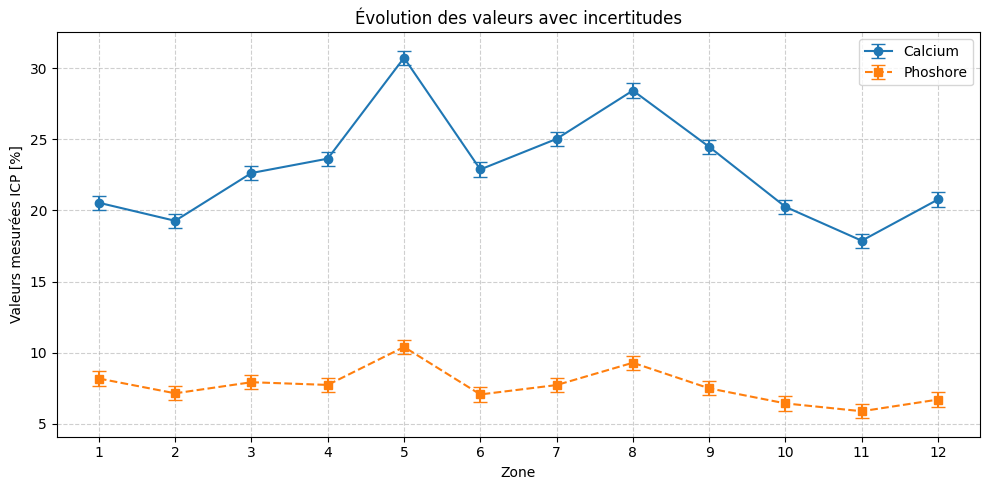

In [21]:
# @title
plt.figure(figsize=(10,5))

# Courbe Calcium
plt.errorbar(
    df["Col_A"],
    df["Col_B1"],
    yerr=df["Col_B2"],
    fmt="o-",
    capsize=5,
    label="Calcium",
    color="tab:blue"
)

# Courbe Phosphore
plt.errorbar(
    df["Col_A"],
    df["Col_C1"],
    yerr=df["Col_C2"],
    fmt="s--",
    capsize=5,
    label="Phoshore",
    color="tab:orange"
)

# Titres
plt.title("Évolution des valeurs avec incertitudes")
plt.xlabel("Zone")
plt.ylabel("Valeurs mesurées ICP [%]")

# Options graphiques
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(np.arange(1, 13, 1))

plt.tight_layout()
plt.show()

---
# Importation du fichier OBJ - Os de Poulet

In [22]:
# @title
# Téléchargement du fichier de maillage
url = "https://github.com/duclanruen/ArtoisProjects/raw/refs/heads/main/chimie/Enzo/chicken-02.obj"
out = "chicken-02.obj"

r = requests.get(url, timeout=60)
r.raise_for_status()

with open(out, "wb") as f:
    f.write(r.content)

print("Fichier téléchargé :",out)

# Création du backend
pv.set_jupyter_backend("static")
loaded = trimesh.load(out)

Fichier téléchargé : chicken-02.obj


---
# Affichage de la bounding box du maillage

In [23]:
# @title
# Définition du fichier trimesh comme le fichier chargé
mesh_tm = loaded

# Récupération des données des faces et des vertices
V = np.asarray(mesh_tm.vertices)
F = np.asarray(mesh_tm.faces)

# Reconstitution du Mesh
mesh = pv.PolyData(V, np.hstack([np.full((len(F), 1), 3), F]).astype(np.int64))

# Extraction de la matrice des couleurs
vc = np.asarray(mesh_tm.visual.vertex_colors)

# Reshape en fonction du format d'origine pour les couleurs
if vc.shape[1] == 4:
    colors = vc[:, :3]
else:
    colors = vc

# Calcul des distances
xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
dx, dy, dz = xmax - xmin, ymax - ymin, zmax - zmin

# Réglage des variables intéractives pour l'affichage de l'os
az = widgets.IntSlider(value=260, min=0, max=360, step=1, description="Azimuth")
el = widgets.IntSlider(value=-10, min=-90, max=90, step=1, description="Elevation")
rl = widgets.IntSlider(value=50,  min=-180, max=180, step=1, description="Roll")

show_bbox = widgets.Checkbox(value=True, description="Bounding box")
show_axes = widgets.Checkbox(value=True, description="Axes")
show_tick = widgets.Checkbox(value=True, description="Ticks")

# Paramétrage de l'UI (User Interface)
ui = widgets.VBox([widgets.HBox([az, el, rl]), widgets.HBox([show_bbox, show_axes, show_tick])])
display(ui)

# Petite marge entre widgets et rendu
display(HTML("<div style='height:12px'></div>"))

# Affichage des widgets
out = widgets.Output()
display(out)

def render(*args):
    with out:
        clear_output(wait=True)

        p = pv.Plotter(notebook=True, window_size=(900, 800))

        if colors is not None:
          mesh.point_data["RGB"] = colors.astype(np.uint8)
          p.add_mesh(mesh, scalars="RGB", rgb=True)
        else:
          p.add_mesh(mesh, color="lightgray")

        #p.add_mesh(mesh)

        if show_bbox.value:
            p.add_mesh(mesh.outline(), line_width=3)

        if show_tick.value:
            p.show_bounds(
            grid="back",
            location="outer",
            ticks="both",
            show_xlabels=False,
            show_ylabels=False,
            show_zlabels=False,
            xtitle=f"{dx:.2f} mm",
            ytitle=f"{dy:.2f} mm",
            ztitle=f"{dz:.2f} mm",
            color="black"
            )

        if show_axes.value:
            p.add_axes()

        p.set_background("white")

        # Réglage de la caméra par angles (azimuth/elevation/roll)
        p.view_isometric()         # point de départ stable
        p.camera.azimuth = az.value
        p.camera.elevation = el.value
        p.camera.roll = rl.value

        # Important : appliquer les changements
        p.camera.zoom(0.75)
        p.render()
        p.show()

for w in [az, el, rl, show_bbox, show_axes]:
    w.observe(render, "value")

render()





Output()

---
# Interpolation des valeurs pour le Phosphore et le Calcium sur le maillage

## 1. Création de liste des abscisses dans un DataFrame

In [24]:
# @title
# Création du vecteur de coordonnées en x
labels["Col_D"]="Distance [mm]"
x_list = np.linspace(0,dx,12)

# Transformation en liste
x_list = x_list.tolist()
df["Col_D"] = x_list

# Affichage du tableau
display(df.rename(columns=labels))


,Zone,Calcium [%],Incertitudes [Ca],Phosphore [%],Incertitudes [P],Distance [mm]
0,1,20.54,0.5,8.18,0.5,0.000000
1,2,19.27,0.5,7.14,0.5,10.020133
2,3,22.63,0.5,7.92,0.5,20.040266
3,4,23.64,0.5,7.73,0.5,30.060399
4,5,30.73,0.5,10.40,0.5,40.080532
5,6,22.88,0.5,7.06,0.5,50.100665
6,7,25.03,0.5,7.72,0.5,60.120798
7,8,28.43,0.5,9.29,0.5,70.140930
8,9,24.47,0.5,7.49,0.5,80.161063
9,10,20.25,0.5,6.43,0.5,90.181196


## 2. Affichage des valeurs en fonction des abscisses

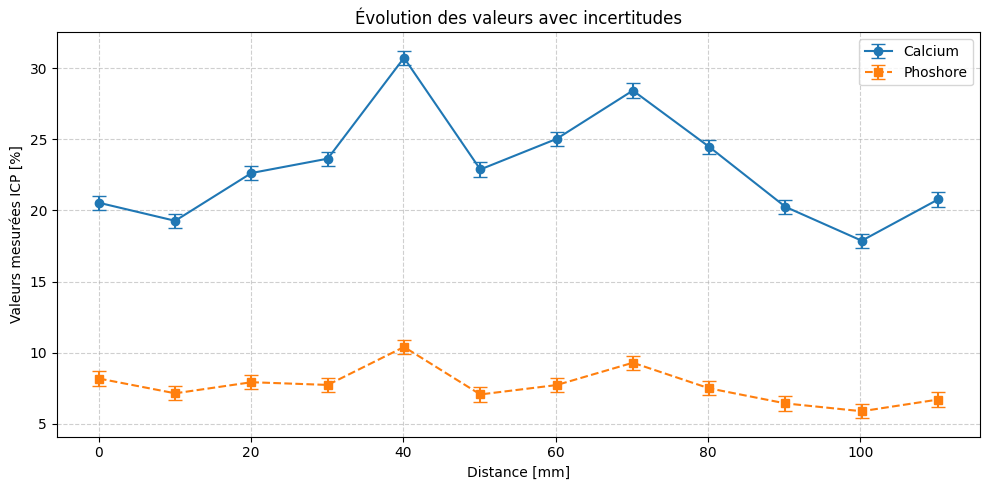

In [25]:
# @title
plt.figure(figsize=(10,5))

# Courbe Calcium
plt.errorbar(
    df["Col_D"],
    df["Col_B1"],
    yerr=df["Col_B2"],
    fmt="o-",
    capsize=5,
    label="Calcium",
    color="tab:blue"
)

# Courbe Phosphore
plt.errorbar(
    df["Col_D"],
    df["Col_C1"],
    yerr=df["Col_C2"],
    fmt="s--",
    capsize=5,
    label="Phoshore",
    color="tab:orange"
)

# Titres
plt.title("Évolution des valeurs avec incertitudes")
plt.xlabel("Distance [mm]")
plt.ylabel("Valeurs mesurées ICP [%]")

# Options graphiques
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## 3. Interpolations des valeurs [Ca, P] sur le maillage

In [26]:
# @title
# Passage du format list au format numpy
# Attention : il y a une différence entre abscisse et distance x_data = x_list + xmin
x_data = np.array(x_list)+xmin
Ca_data = np.array(df["Col_B1"])
P_data = np.array(df["Col_C1"])

# Position en x de chaque point du maillage
x_vertices = mesh.points[:, 0]

# Création de la fonction d'interpolation
Ca_vertices = np.interp(x_vertices, x_data, Ca_data)
P_vertices = np.interp(x_vertices, x_data, P_data)

# Ajout du champ scalaire aux points
mesh.point_data["Ca"] = Ca_vertices
mesh.point_data["P"] = P_vertices

print("Interpolation Ca et P effectuée")

Interpolation Ca et P effectuée


## 4. Affichage de la cartographie

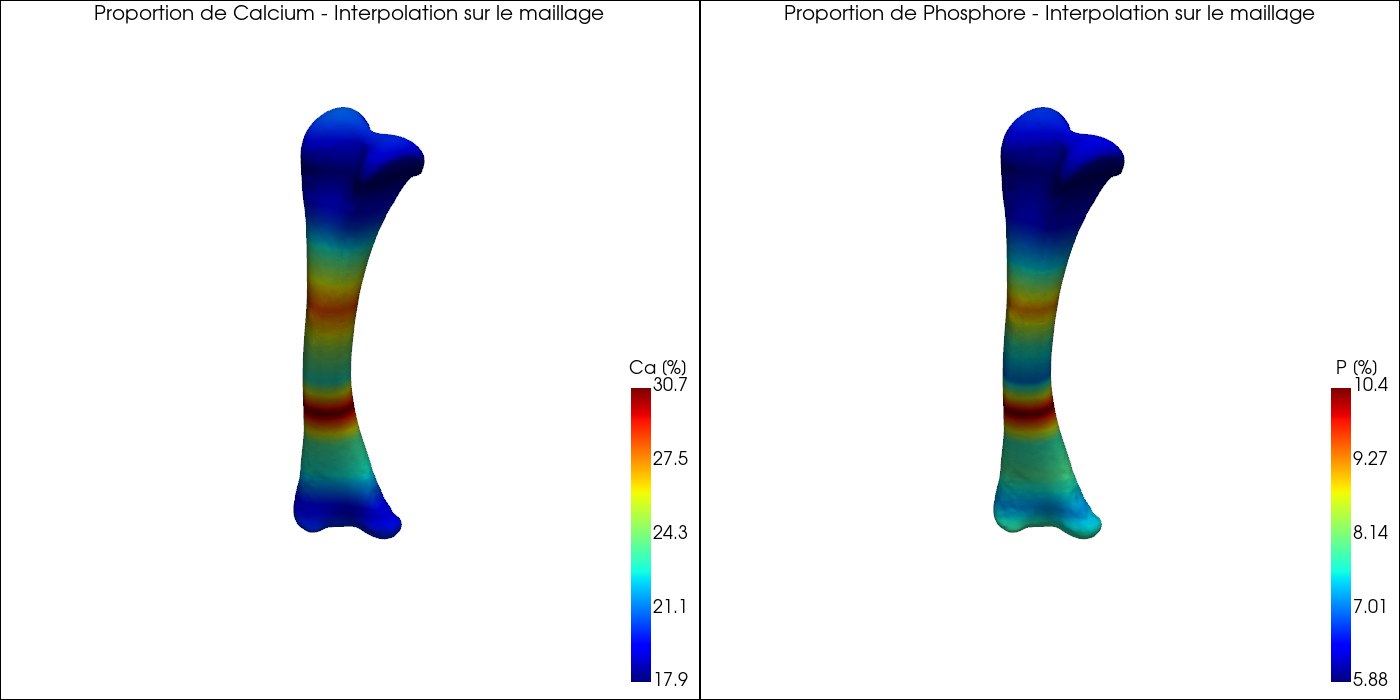

In [27]:
# @title
# Pour afficher les deux maillages en même temps, on va en faire des copies indépendantes
pv.set_jupyter_backend("static")

# Copie sans partage des données
m1 = mesh.copy(deep=True)
m2 = mesh.copy(deep=True)

# Forcer le champ actif dans le subplot
m1.set_active_scalars("Ca")
m2.set_active_scalars("P")

# Affichage des deux maillages
p = pv.Plotter(shape=(1,2), notebook=True, window_size=(1400, 700))

# -- Gauche --
p.subplot(0, 0)
p.add_mesh(
    m1,
    scalars="Ca",
    cmap="jet",
    clim=[float(np.nanmin(Ca_vertices)), float(np.nanmax(Ca_vertices))],
    show_scalar_bar=True,
    scalar_bar_args={"title": "Ca [%]", "vertical":True},
)

# Réglage de la caméra par angles (azimuth/elevation/roll)
p.view_isometric()
p.camera.azimuth = az.value
p.camera.elevation = el.value
p.camera.roll = rl.value
p.camera.zoom(0.75)
p.set_background("white")

p.add_text(
    "Proportion de Calcium - Interpolation sur le maillage",
    position="upper_edge",
    font_size=8,
)

# -- Droite --
p.subplot(0, 1)
p.add_mesh(
    m2,
    scalars="P",
    cmap="jet",
    clim=[float(np.nanmin(P_vertices)), float(np.nanmax(P_vertices))],
    show_scalar_bar=True,
    scalar_bar_args={"title": "P [%]", "vertical":True},
)

p.add_text(
    "Proportion de Phosphore - Interpolation sur le maillage",
    position="upper_edge",
    font_size=8,
)

p.link_views()

p.show()

# Interpolation des valeurs de densité sur le maillage
## 1. Ajout des volumes, masses et calcul des masses volumiques

In [28]:
# Création du vecteur de coordonnées en x
labels["Col_E"]="Masses [g]"
labels["Col_F"]="Volumes [g/cm3]"
labels["Col_G"]="Masses volumiques [g/cm3]"

masses = [1.442,1.056,0.874,0.718,0.707,0.874,0.800,1.020,0.754,1.163,1.791,1.112]
volumes = [2.236,1.266,0.888,0.561,0.525,0.675,0.550,0.634,0.588,1.002,2.066,1.598]

rho = np.array(masses)/np.array(volumes)
rho = rho.tolist()

# Ajout à la dataFrame
df["Col_E"] = masses
df["Col_F"] = volumes
df["Col_G"] = rho

# 2. Affichage du tableau

In [29]:
display(df.rename(columns=labels))

,Zone,Calcium [%],Incertitudes [Ca],Phosphore [%],Incertitudes [P],Distance [mm],Masses [g],Volumes [g/cm3],Masses volumiques [g/cm3]
0,1,20.54,0.5,8.18,0.5,0.000000,1.442,2.236,0.644902
1,2,19.27,0.5,7.14,0.5,10.020133,1.056,1.266,0.834123
2,3,22.63,0.5,7.92,0.5,20.040266,0.874,0.888,0.984234
3,4,23.64,0.5,7.73,0.5,30.060399,0.718,0.561,1.279857
4,5,30.73,0.5,10.40,0.5,40.080532,0.707,0.525,1.346667
5,6,22.88,0.5,7.06,0.5,50.100665,0.874,0.675,1.294815
6,7,25.03,0.5,7.72,0.5,60.120798,0.800,0.550,1.454545
7,8,28.43,0.5,9.29,0.5,70.140930,1.020,0.634,1.608833
8,9,24.47,0.5,7.49,0.5,80.161063,0.754,0.588,1.282313
9,10,20.25,0.5,6.43,0.5,90.181196,1.163,1.002,1.160679


## 3. Interpolation des valeurs de masses volumiques sur le maillage

In [30]:
# @title
# Vérifier que le vecteur des abscisses soit en ordre croissant
rho_data = np.array(df["Col_G"])

# Création de la fonction d'interpolation
rho_vertices = np.interp(x_vertices, x_data, rho_data)

# Ajout du champ scalaire aux points
mesh.point_data["rho"] = rho_vertices

print("Interpolation Rho effectuée")

Interpolation Rho effectuée


## 4. Affichage de la masse volumique sur le maillage

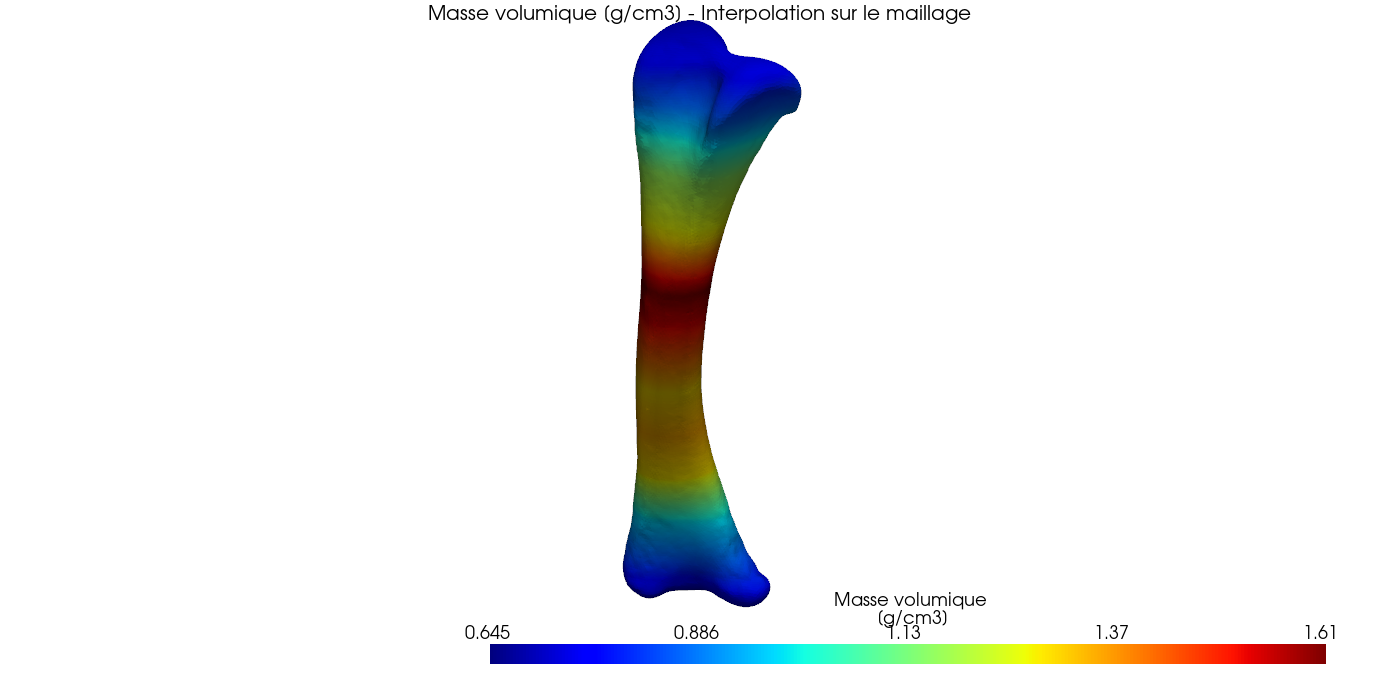

In [31]:
# @title
# Pour afficher les deux maillages en même temps, on va en faire des copies indépendantes
pv.set_jupyter_backend("static")

# Copie sans partage des données
m3 = mesh.copy(deep=True)

# Forcer le champ actif dans le subplot
m3.set_active_scalars("rho")

# Affichage des deux maillages
p = pv.Plotter(notebook=True, window_size=(1400, 700))

p.add_mesh(
    m3,
    scalars="rho",
    cmap="jet",
    clim=[float(np.nanmin(rho_vertices)), float(np.nanmax(rho_vertices))],
    show_scalar_bar=True,
    scalar_bar_args={"title": "Masse volumique\n [g/cm3]"},
)

# Réglage de la caméra par angles (azimuth/elevation/roll)
p.view_isometric()
p.camera.azimuth = az.value
p.camera.elevation = el.value
p.camera.roll = rl.value
p.set_background("white")

p.add_text(
    "Masse volumique [g/cm3] - Interpolation sur le maillage",
    position="upper_edge",
    font_size=8,
)

p.show()

---
## 5. Export des données au format VTK

In [32]:
# @title
# Sauvegarde au format VTK
mesh.save("chicken-02.vtk")
print("Fichier VTK sauvegardé")

Fichier VTK sauvegardé


# Analyse linéaire

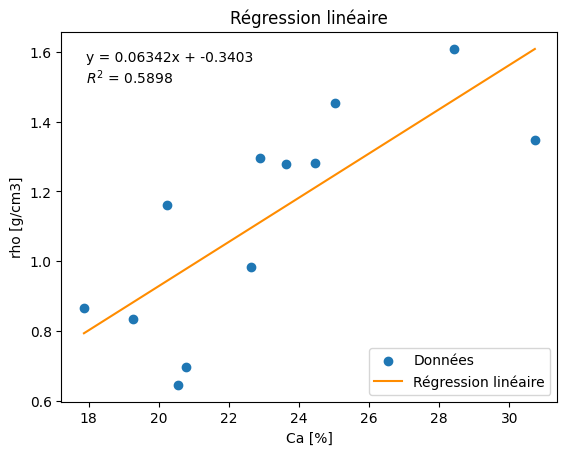

Résultats de l'analyse
-------------------------------------------------
Pente : 0.06342
Ordonnée à l'origine : -0.3403
Coefficient de détermination : 0.5898


In [33]:
# Analyse de la relation entre taux de Ca et densité
#---------------------------------------------------

# Création d'un mini tableau avec
#   en x les valeurs du Ca[%]
#   en y les valeurs des masses volulmiqes [g/cm3]
data_Ca_rho = df[['Col_B1','Col_G']]
x_Ca_rho = data_Ca_rho['Col_B1'].to_numpy(dtype=float)
y_Ca_rho = data_Ca_rho['Col_G'].to_numpy(dtype=float)

# Interpolation linéaire
a,b = np.polyfit(x_Ca_rho,y_Ca_rho,1)

# Calcul du R2
y_pred = a*x_Ca_rho + b
ss_res = np.sum((y_Ca_rho - y_pred)**2)
ss_tot = np.sum((y_Ca_rho - np.mean(y_Ca_rho))**2)
r2 = 1 - (ss_res / ss_tot)

# Affichage des résultats
plt.figure()
plt.scatter(x_Ca_rho, y_Ca_rho, label="Données")
x_line = np.linspace(np.min(x_Ca_rho), np.max(x_Ca_rho), 200)
y_line = a * x_line + b
plt.plot(x_line, y_line, label="Régression linéaire", color='darkorange')

eq = f"y = {a:.4g}x + {b:.4g}\n$R^2$ = {r2:.4f}"
plt.title("Régression linéaire")
plt.xlabel("Ca [%]")
plt.ylabel("rho [g/cm3]")
plt.legend()

# place annotation in the plot (top-left)
plt.text(0.05, 0.95, eq, transform=plt.gca().transAxes, va="top")

plt.show()

print("Résultats de l'analyse")
print("-------------------------------------------------")
print(f"Pente : {a:.4g}")
print(f"Ordonnée à l'origine : {b:.4g}")
print(f"Coefficient de détermination : {r2:.4f}")